# Word Embeddings

Exercises:

1. Are you able to create an interactive progress bar for the word embedding training process? [tqdm](https://tqdm.github.io/), could be of your help.
2. Can you also create a live plot tracking the training loss of the embedding model? [livelossplot](https://p.migdal.pl/livelossplot/), could be of your help as well as other tools such as [Tensorboard](https://www.tensorflow.org/tensorboard).

In [1]:
!pip install tqdm
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from livelossplot import PlotLosses

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pierpaolo28/Anaconda-Machine-Learning-Visualization-Course/main/Data/books.csv', on_bad_lines='skip')
df = df.reset_index(drop=True)
df.authors = [i.split('/')[0] for i in df.authors]
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
df = df.drop_duplicates('authors')
df = df.reset_index(drop=True)
df = df[:30]
size = len(df.authors)
# Considering the whole dataset as training set to perform labeling and
# scaling, since we are just interested in creating the embeddings
# but no further predictions are going to be performed
encoder, scaler = LabelEncoder(), MinMaxScaler()
aut = encoder.fit_transform(df.authors) 
rat = scaler.fit_transform(df[['average_rating']])

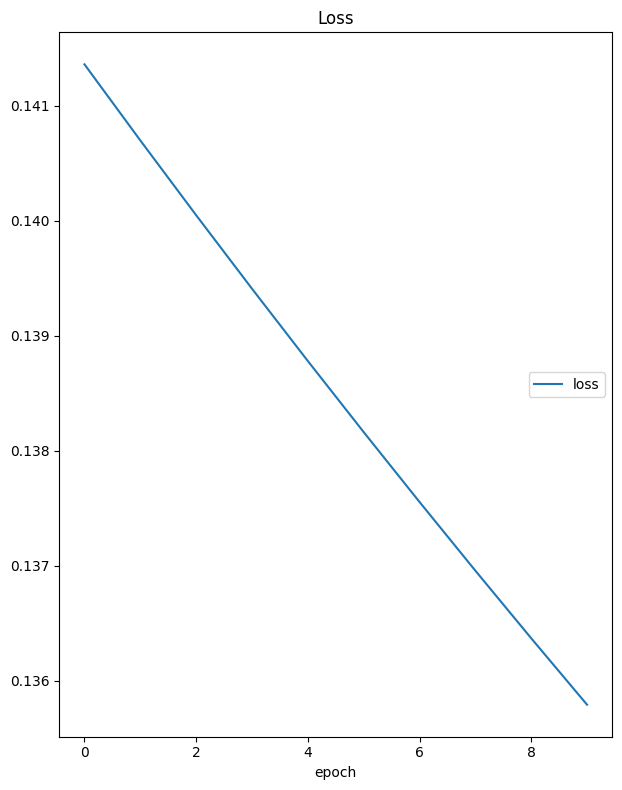

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

Loss
	loss             	 (min:    0.136, max:    0.141, cur:    0.136)


In [5]:
class Latent_Embed(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Latent_Embed, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(3, 2)
        self.linear2 = nn.Linear(2, 1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        return out


aut_t = torch.tensor(aut)
rat_t = torch.tensor(rat)
loss_function = nn.MSELoss()
model = Latent_Embed(size, 3)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
liveloss = PlotLosses()

for epoch in tqdm(range(10)):
    total_loss = 0
    logs = {}
    for context, target in zip(aut_t, rat_t):
        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs.double(), target.view(1).double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    logs['loss'] = total_loss/len(aut_t)
    liveloss.update(logs)
    liveloss.send()